In [1]:
import pickle 
import numpy as np 
import pandas as pd 
from sklearn.metrics import r2_score 
import matplotlib.pyplot as plt 

In [2]:
#load saved data 
obj = pd.read_pickle('data/update2_pickle.pickle')

# Profit Calculations

## Helper Functions 

In [3]:
#find index 
name_array = np.array(obj[0])
all_predicted_values = obj[1]

#find relevant index from saved data
def index_finder(csv_name):

    #find the index from the loaded object
    idx = np.where(name_array == csv_name)[0][0]
    
    return idx 

#get the predictions from Saved Data
def preds(csv_name):
    
    #pull index predicted values
    values = pd.DataFrame(all_predicted_values[index_finder(csv_name)], 
                                   columns = ['Open', 'High', 'Low', 'Close'])
    
    #opening values
    predicted_values = np.array(values.iloc[:,0])
    
    return predicted_values


#Get the actual values from the saved data 
def actual(csv_name):
    
    #get actual opening values 
    df = pd.read_csv('data/{}'.format(csv_name))
    actual_vals = np.array(df.iloc[:,1])
    
    return actual_vals

## Calculate Buy Decisions and Averages

In [4]:
#running average, std deviations for previous k hours (opening price) 
def moving_averages(csv_name, k, cut_off):
    
    """
    For specified csv:
        - return the weighted averages
        - std deviations by window size k
        
    In order to avoid unncessary risk, you can specifya period (say hour 85) to cut off buying
    
        
    Output: Dataframe with Actual Values within the last 100 Hours of Trading
            Predicted Values
            Moving Averages for specified-k Day Lag 
            Std Deviations for the Moving Averages 
    """
    
    #load actual/predicted values
    actual_values = actual(csv_name)[-100 - k - 2:]
    predicted_values = preds(csv_name)
     
    #start calculations for the moving averages 
    moving_avs = []
    moving_stds = []
    
    for i,j in enumerate(predicted_values):
    
        #values needed
        block = actual_values[i:k+i]

        #compute mean, std append
        avg, std = np.average(block), np.std(block)
        moving_avs.append(avg)
        moving_stds.append(std)
    
    
    #recast to be the final 100 hours 
    actual_values = actual_values[k+2:]
    #print(len(actual_values))
    
    #For Buy Decision: Predicted - Moving Averages <0 and less than std of mean 
    buy_decision = []
    net_values = []
    
    #Calculate
    for i in range(100):
        
        #Differences between predictions, moving average of actual values 
        difference = predicted_values[i] - moving_avs[i]
        
        #if you buy based on the prediction, this is the difference between predicted and actual
        actual_worth = predicted_values[i] - actual_values[i]
        
        
        #ther predicted value is less than the standard deviation
        if (difference < 0) & (abs(difference) > moving_stds[i]) & (i <= cut_off):  
            buy_decision.append(1)
            net_values.append(actual_worth)
            
        else: 
            buy_decision.append(0)
            net_values.append(0)
    
    
    return pd.DataFrame({'Actual Values':actual_values, 
                         'Predicted Values':predicted_values,
                        'Moving Averages for {} Day Lag'.format(k):moving_avs, 
                        'Std Deviations':moving_stds, 
                        'Buy Coin?': buy_decision, 
                        'Difference': net_values})

## Calculate Sell Decisions

In [5]:
def buy_sell(df):
    
    """
    Given weighted averages, standard deviations, choose stocks purchased at indices within
    the last 100 hours to sell off. 
    
    Sell decision is where difference between predicted value of coin is at least one standard 
    deviation above the price the coin was purchased at 
    
    Returns a dataframe of the trades made and their respective statistics, assets held after 
    """
    
    sell_time = []
    sold_array = []
    baseline = []
    
    buy_decisions = np.where(df.iloc[:,4] == 1)[0]
    
    
    #in subsequent time periods, we take sell greedily 
    #1st time the predicted value is above 1 std, we sell 
    
    for time in buy_decisions: 
        
        for i in range(time, df.shape[0]): 
            
            #predicted value one standard deviation above actual value 
            #predicted pattern at hour i 
            predicted_value = df.iloc[i, 1]

            #purchase price 
            buy_time_actual = df.iloc[time, 0]

            #running adjusted std dev
            std_dev_actual = df.iloc[i, 3]

            #measure the potential difference between prediced price and the purchase, 
            potential_difference = predicted_value - buy_time_actual

            # if the potential difference is greater than 1 std at current time, sell at open else hold
            if potential_difference > std_dev_actual: 

                #sell point
                sell_point = df.iloc[i,0]
                cash_flow = sell_point-buy_time_actual
                baseline.append(cash_flow)

                sold_array.append(time)
                sell_time.append(i)
                break
    
    #DF Trades  
    rev_df = pd.DataFrame({'Asset Purchased at time t':sold_array, 
                       'Sold at Time':sell_time, 'Net Revenue': baseline})
    
    profitable_trades_ratio = len(np.where(np.array(baseline) > 0)[0])/len(baseline)
    
    
    #Total Earnings From Trades
    total_earnings = np.sum(baseline)
    
    #Purchased Assets Still Held 
    assets_held = list(set(buy_decisions) - set(sold_array))
    
    #Total Value of Assets Held
    assets_held_value = np.sum([df.iloc[i,0] for i in assets_held])
    
    
    return [rev_df, profitable_trades_ratio, total_earnings, assets_held, assets_held_value]

In [85]:
profit = 0
held = 0

#Money made
for i in obj[0]:
    data = moving_averages(i,25,85)
    performance = buy_sell(data)[2]
    profit += performance
    
#Value of Assets Still Held 
for i in obj[0]:
    data = moving_averages(i,25,85)
    asset = buy_sell(data)[4]
    held += asset
    
print(profit)
print(held)

9495.835443870023
1002.6839400000002


# Modeling 

In [7]:
#first index is names, second index is predicted, third is r squared, fourth is mape
#create array of coins I care about 

csv_array = ['BTCUSD.csv', 'ETHUSD.csv', 'SOLUSD.csv', 'ADAUSD.csv', 'XRPBUSD.csv',
             'DOTUSD.csv', 'AVAXUSD.csv', 'DOGEUSD.csv', 'SHIBUSD.csv', 'MATICUSD.csv']

index_array = []
name_array = np.array(obj[0])
r2_array = []
opening_mape = []

print(name_array)

for i in name_array: 
    #load indices for the coin pairs that we need 
    idx = np.where(name_array == i)[0][0]
    index_array.append(idx)
    
    #get data frame that we need for coin pairs 
    df = pd.read_csv('data/{}'.format(i))

    
    #predicted values 
    values = pd.DataFrame(obj[1][idx], columns = ['Predicted Open', 'High', 'Low', 'Close'])
    predicted_values = values.iloc[:,0]
    
    #actual values
    actual_values = df.iloc[-100:]
    print(actual_values)
    actual_values = actual_values.iloc[:,1]
    
    r2 = r2_score(actual_values,predicted_values)
    r2_array.append(r2)
    
    mape_score = obj[3][idx][1]
    opening_mape.append(mape_score)
    
    #r2 scores
    #print("name:{}, \n MAPE Open:{}, \n r2 score:{}".format(obj[0][idx], obj[3][idx][1], r2))
    
    

['LTCBUSD.csv' 'EGLDBUSD.csv' 'GALAUSD.csv' 'MIRBUSD.csv' 'CELRBUSD.csv'
 'PYRBUSD.csv' 'POWRUSD.csv' 'XVSBUSD.csv' 'BNBBUSD.csv' 'YFIBUSD.csv'
 'ACMBUSD.csv' 'EOSUSD.csv' 'BAKEBUSD.csv' 'QTUMBUSD.csv' 'FISBUSD.csv'
 'ARBUSD.csv' 'MLNUSD.csv' 'COVALUSD.csv' 'VETBUSD.csv' 'ERNBUSD.csv'
 'IOTXBUSD.csv' 'ELFBUSD.csv' 'DOTUSDT.csv' 'LAZIOBUSD.csv' 'MDTUSD.csv'
 'LINABUSD.csv' 'SNXBUSD.csv' 'ANKRBUSD.csv' 'HIVEBUSD.csv' 'RENBUSD.csv'
 'BICOBUSD.csv' 'ATOMBUSD.csv' 'DARBUSD.csv' 'POLYBUSD.csv' 'MATICUSD.csv'
 'DOGEUSD.csv' 'RARIUSD.csv' 'MANAUSD.csv' 'COMPBUSD.csv' 'INJBUSD.csv'
 'THETABUSD.csv' 'ZECUSD.csv' 'DIABUSD.csv' 'ALGOUSD.csv' 'AMPUSD.csv'
 'CTSIBUSD.csv' 'FTTBUSD.csv' 'CELOBUSD.csv' 'BADGERBUSD.csv' 'RENUSD.csv'
 'BALUSD.csv' 'NKNUSD.csv' 'OOKIBUSD.csv' 'BADGERUSD.csv' 'DYDXBUSD.csv'
 'SOLBUSD.csv' 'LPTUSD.csv' 'CROUSD.csv' 'ZRXBUSD.csv' 'JSTBUSD.csv'
 'HNTBUSD.csv' 'BCHUSD.csv' 'ETHUSD.csv' 'KRLUSD.csv' 'BATUSD.csv'
 'AERGOBUSD.csv' 'PLAUSD.csv' 'AVAXUSDT.csv' 'HIGHBUSD.csv' 'BCHB

                 datetime  SNXBUSD_open  SNXBUSD_high  SNXBUSD_low  \
3524  2022-05-27 20:00:00         2.502         2.517        2.466   
3525  2022-05-27 21:00:00         2.482         2.500        2.429   
3526  2022-05-27 22:00:00         2.437         2.471        2.409   
3527  2022-05-27 23:00:00         2.463         2.514        2.455   
3528  2022-05-28 00:00:00         2.502         2.538        2.491   
...                   ...           ...           ...          ...   
3619  2022-05-31 19:00:00         3.123         3.155        3.066   
3620  2022-05-31 20:00:00         3.125         3.151        3.102   
3621  2022-05-31 21:00:00         3.143         3.146        3.071   
3622  2022-05-31 22:00:00         3.091         3.096        3.053   
3623  2022-05-31 23:00:00         3.070         3.124        3.028   

      SNXBUSD_close  
3524          2.484  
3525          2.440  
3526          2.468  
3527          2.506  
3528          2.510  
...             ...  
3619 

                 datetime  OOKIBUSD_open  OOKIBUSD_high  OOKIBUSD_low  \
3524  2022-05-27 20:00:00        0.00524        0.00525       0.00510   
3525  2022-05-27 21:00:00        0.00511        0.00516       0.00505   
3526  2022-05-27 22:00:00        0.00506        0.00518       0.00501   
3527  2022-05-27 23:00:00        0.00518        0.00530       0.00513   
3528  2022-05-28 00:00:00        0.00524        0.00529       0.00521   
...                   ...            ...            ...           ...   
3619  2022-05-31 19:00:00        0.00604        0.00607       0.00591   
3620  2022-05-31 20:00:00        0.00604        0.00605       0.00595   
3621  2022-05-31 21:00:00        0.00594        0.00595       0.00582   
3622  2022-05-31 22:00:00        0.00584        0.00584       0.00578   
3623  2022-05-31 23:00:00        0.00580        0.00583       0.00575   

      OOKIBUSD_close  
3524         0.00510  
3525         0.00507  
3526         0.00518  
3527         0.00524  
3528    

                 datetime  AUCTIONUSD_open  AUCTIONUSD_high  AUCTIONUSD_low  \
3524  2022-05-27 20:00:00             6.24             6.27            6.15   
3525  2022-05-27 21:00:00             6.19             6.23            6.12   
3526  2022-05-27 22:00:00             6.14             6.17            6.10   
3527  2022-05-27 23:00:00             6.12             6.15            6.06   
3528  2022-05-28 00:00:00             6.11             6.23            6.08   
...                   ...              ...              ...             ...   
3619  2022-05-31 19:00:00             7.21             7.89            7.17   
3620  2022-05-31 20:00:00             7.43             7.51            7.20   
3621  2022-05-31 21:00:00             7.34             7.38            7.24   
3622  2022-05-31 22:00:00             7.26             7.31            7.23   
3623  2022-05-31 23:00:00             7.27             7.30            7.19   

      AUCTIONUSD_close  
3524              6.18  
3

                 datetime  RVNBUSD_open  RVNBUSD_high  RVNBUSD_low  \
3524  2022-05-27 20:00:00       0.02690       0.02690      0.02614   
3525  2022-05-27 21:00:00       0.02620       0.02623      0.02566   
3526  2022-05-27 22:00:00       0.02582       0.02658      0.02572   
3527  2022-05-27 23:00:00       0.02661       0.02666      0.02634   
3528  2022-05-28 00:00:00       0.02651       0.02700      0.02640   
...                   ...           ...           ...          ...   
3619  2022-05-31 19:00:00       0.02971       0.03018      0.02928   
3620  2022-05-31 20:00:00       0.02988       0.02990      0.02956   
3621  2022-05-31 21:00:00       0.02976       0.02987      0.02922   
3622  2022-05-31 22:00:00       0.02929       0.02929      0.02890   
3623  2022-05-31 23:00:00       0.02897       0.02922      0.02875   

      RVNBUSD_close  
3524        0.02614  
3525        0.02592  
3526        0.02658  
3527        0.02656  
3528        0.02675  
...             ...  
3619 

                 datetime  VOXELBUSD_open  VOXELBUSD_high  VOXELBUSD_low  \
3524  2022-05-27 20:00:00          0.5978          0.6224         0.5832   
3525  2022-05-27 21:00:00          0.5846          0.5864         0.5721   
3526  2022-05-27 22:00:00          0.5783          0.5931         0.5772   
3527  2022-05-27 23:00:00          0.5902          0.5943         0.5852   
3528  2022-05-28 00:00:00          0.5883          0.6037         0.5873   
...                   ...             ...             ...            ...   
3619  2022-05-31 19:00:00          0.6763          0.6789         0.6618   
3620  2022-05-31 20:00:00          0.6703          0.6719         0.6588   
3621  2022-05-31 21:00:00          0.6616          0.6639         0.6542   
3622  2022-05-31 22:00:00          0.6646          0.7081         0.6645   
3623  2022-05-31 23:00:00          0.6850          0.6860         0.6734   

      VOXELBUSD_close  
3524           0.5838  
3525           0.5780  
3526           

                 datetime  ASMUSD_open  ASMUSD_high  ASMUSD_low  ASMUSD_close
3524  2022-05-27 20:00:00      0.02441      0.02517     0.02421       0.02421
3525  2022-05-27 21:00:00      0.02420      0.02620     0.02389       0.02496
3526  2022-05-27 22:00:00      0.02530      0.02597     0.02505       0.02548
3527  2022-05-27 23:00:00      0.02553      0.02606     0.02543       0.02543
3528  2022-05-28 00:00:00      0.02552      0.02560     0.02488       0.02546
...                   ...          ...          ...         ...           ...
3619  2022-05-31 19:00:00      0.02962      0.02988     0.02936       0.02947
3620  2022-05-31 20:00:00      0.02952      0.02960     0.02931       0.02938
3621  2022-05-31 21:00:00      0.02938      0.02947     0.02902       0.02946
3622  2022-05-31 22:00:00      0.02947      0.02986     0.02940       0.02971
3623  2022-05-31 23:00:00      0.02971      0.02971     0.02949       0.02960

[100 rows x 5 columns]
                 datetime  BATBUSD_open 

                 datetime  EOSBUSD_open  EOSBUSD_high  EOSBUSD_low  \
3524  2022-05-27 20:00:00         1.237         1.237        1.217   
3525  2022-05-27 21:00:00         1.218         1.229        1.210   
3526  2022-05-27 22:00:00         1.211         1.232        1.206   
3527  2022-05-27 23:00:00         1.231         1.237        1.225   
3528  2022-05-28 00:00:00         1.234         1.253        1.230   
...                   ...           ...           ...          ...   
3619  2022-05-31 19:00:00         1.380         1.406        1.361   
3620  2022-05-31 20:00:00         1.402         1.402        1.373   
3621  2022-05-31 21:00:00         1.378         1.385        1.372   
3622  2022-05-31 22:00:00         1.382         1.382        1.350   
3623  2022-05-31 23:00:00         1.368         1.374        1.354   

      EOSBUSD_close  
3524          1.218  
3525          1.215  
3526          1.231  
3527          1.235  
3528          1.243  
...             ...  
3619 

                 datetime  RBNUSD_open  RBNUSD_high  RBNUSD_low  RBNUSD_close
3524  2022-05-27 20:00:00         0.29         0.30        0.29          0.29
3525  2022-05-27 21:00:00         0.29         0.30        0.29          0.29
3526  2022-05-27 22:00:00         0.30         0.30        0.29          0.30
3527  2022-05-27 23:00:00         0.30         0.30        0.29          0.30
3528  2022-05-28 00:00:00         0.30         0.30        0.29          0.29
...                   ...          ...          ...         ...           ...
3619  2022-05-31 19:00:00         0.31         0.32        0.31          0.32
3620  2022-05-31 20:00:00         0.31         0.32        0.31          0.31
3621  2022-05-31 21:00:00         0.31         0.32        0.31          0.32
3622  2022-05-31 22:00:00         0.31         0.32        0.30          0.32
3623  2022-05-31 23:00:00         0.32         0.33        0.31          0.32

[100 rows x 5 columns]
                 datetime  CTKBUSD_open 

                 datetime  FILUSD_open  FILUSD_high  FILUSD_low  FILUSD_close
3524  2022-05-27 20:00:00         7.29         7.36        7.26          7.30
3525  2022-05-27 21:00:00         7.31         7.36        7.26          7.28
3526  2022-05-27 22:00:00         7.25         7.33        7.24          7.26
3527  2022-05-27 23:00:00         7.28         7.28        7.14          7.21
3528  2022-05-28 00:00:00         7.22         7.40        7.21          7.40
...                   ...          ...          ...         ...           ...
3619  2022-05-31 19:00:00         7.96         8.02        7.94          7.99
3620  2022-05-31 20:00:00         8.01         8.06        7.96          8.05
3621  2022-05-31 21:00:00         8.06         8.06        8.00          8.01
3622  2022-05-31 22:00:00         8.01         8.19        8.01          8.19
3623  2022-05-31 23:00:00         8.16         8.17        8.04          8.09

[100 rows x 5 columns]
                 datetime  COTIUSD_open 

                 datetime  XTZUSD_open  XTZUSD_high  XTZUSD_low  XTZUSD_close
3524  2022-05-27 20:00:00         1.81         1.85        1.80          1.83
3525  2022-05-27 21:00:00         1.84         1.85        1.82          1.83
3526  2022-05-27 22:00:00         1.83         1.85        1.82          1.83
3527  2022-05-27 23:00:00         1.84         1.84        1.79          1.81
3528  2022-05-28 00:00:00         1.82         1.89        1.81          1.89
...                   ...          ...          ...         ...           ...
3619  2022-05-31 19:00:00         2.07         2.08        2.06          2.08
3620  2022-05-31 20:00:00         2.07         2.09        2.06          2.09
3621  2022-05-31 21:00:00         2.08         2.09        2.07          2.08
3622  2022-05-31 22:00:00         2.08         2.11        2.06          2.10
3623  2022-05-31 23:00:00         2.10         2.12        2.07          2.09

[100 rows x 5 columns]
                 datetime  TRXBUSD_open 

In [8]:
##Coins with Highest R2 Scores

coins = [i.split('.')[0] for i in name_array]
# coins


results_df = pd.DataFrame({'Coin':coins, 'R2 Score':r2_array, 'MAPE':opening_mape}, 
                          columns = ['Coin', 'R2 Score', 'MAPE'])

results_df
top_25 = results_df.sort_values(by = ['R2 Score'], ascending = False)[0:25]
top_25

Coin  R2 Score      MAPE
309     ADAUSD  0.944335  0.019575
167    ADABUSD  0.943310  0.020126
179     XLMUSD  0.941716  0.010710
200    XLMBUSD  0.938424  0.011709
325    ETHTUSD  0.933255  0.008584
288    BTCTUSD  0.927344  0.007018
120   AAVEBUSD  0.923814  0.019372
231    WBTCUSD  0.922221  0.008812
254    AVABUSD  0.918940  0.013238
1     EGLDBUSD  0.918745  0.020303
284    BTCBUSD  0.918716  0.007966
40   THETABUSD  0.918713  0.017727
238    ILVBUSD  0.914927  0.015594
100   LINKBUSD  0.912294  0.017172
209  WAVESBUSD  0.911755  0.059443
252    ETHBUSD  0.909125  0.009780
306     UNIUSD  0.907897  0.018002
60     HNTBUSD  0.907664  0.024753
165    XRPBUSD  0.906631  0.009860
146    DASHUSD  0.906155  0.012360
233    C98BUSD  0.905889  0.025160
98     ENJBUSD  0.905028  0.017645
62      ETHUSD  0.904955  0.010218
130   RUNEBUSD  0.904583  0.025081
118   NEARBUSD  0.904385  0.018961

In [9]:
##Coins with Highest R2 Scores - only in USD

# condition1 = results_df['Coin'].str.contains('BUSD') == False
# condition2 = results_df['Coin'].str.contains('USDC') == False
# condition3 = results_df['Coin'].str.contains('TUSD') == False
# condition4 = results_df['Coin'].str.contains('USDT') == False


usd_only = results_df[~results_df.Coin.str.contains('|'.join(['BUSD']))]
usd_only = usd_only[~usd_only.Coin.str.contains('|'.join(['USDC']))]
usd_only = usd_only[~usd_only.Coin.str.contains('|'.join(['TUSD']))]
usd_only = usd_only[~usd_only.Coin.str.contains('|'.join(['USDT']))]


#usd_only = results_df[condition1 | condition2 | condition3| condition4]

top_usd = usd_only.sort_values(by = ['R2 Score'], ascending = False)[0:25]
top_usd

Coin  R2 Score      MAPE
309    ADAUSD  0.944335  0.019575
179    XLMUSD  0.941716  0.010710
231   WBTCUSD  0.922221  0.008812
306    UNIUSD  0.907897  0.018002
146   DASHUSD  0.906155  0.012360
62     ETHUSD  0.904955  0.010218
61     BCHUSD  0.899554  0.012079
322   AAVEUSD  0.897348  0.020937
180    BTCUSD  0.895879  0.008366
72     ENSUSD  0.890785  0.021840
214   LINKUSD  0.887864  0.017985
11     EOSUSD  0.884888  0.011161
57     CROUSD  0.882538  0.012883
142   BANDUSD  0.882512  0.021032
207    ENJUSD  0.878338  0.017994
96     LTCUSD  0.876169  0.010202
215    RLCUSD  0.871433  0.023897
43    ALGOUSD  0.870045  0.015721
105   IOTXUSD  0.869493  0.026447
37    MANAUSD  0.868815  0.016604
151    OMGUSD  0.868407  0.015628
234    AXSUSD  0.868185  0.027943
243  QUICKUSD  0.866032  0.016568
271    IMXUSD  0.865794  0.024717
49     RENUSD  0.859575  0.019745

In [10]:
# actual_values = pd.read_csv('data/ADAUSD.csv')
# labels = actual_values.iloc[-100:,0]
# final = [i.split('2022')[1][1::] for i in labels]

# Visualize the Top 25 ($R^2$) Coin/USD Pairs 

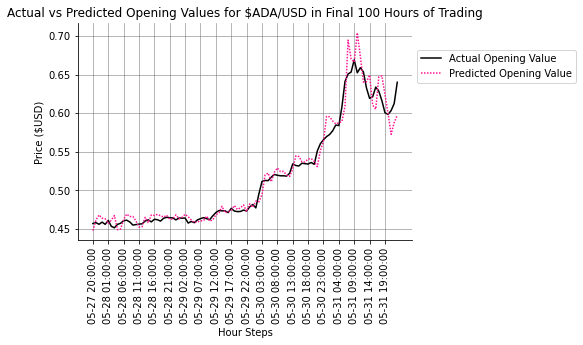

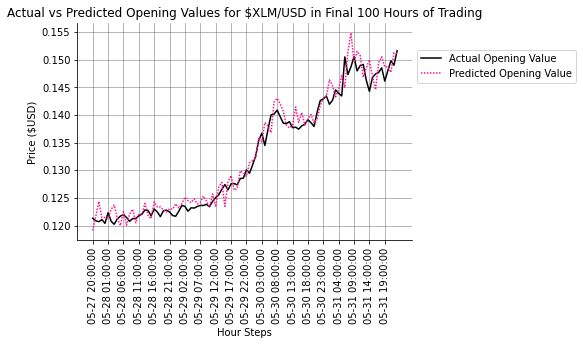

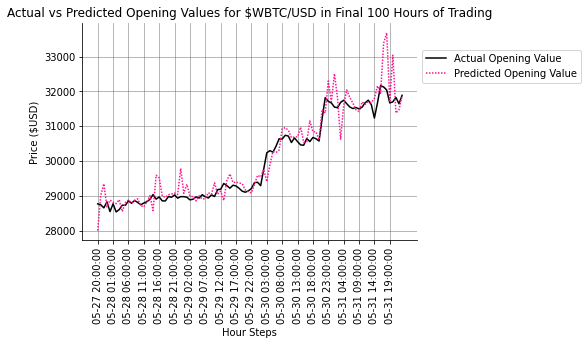

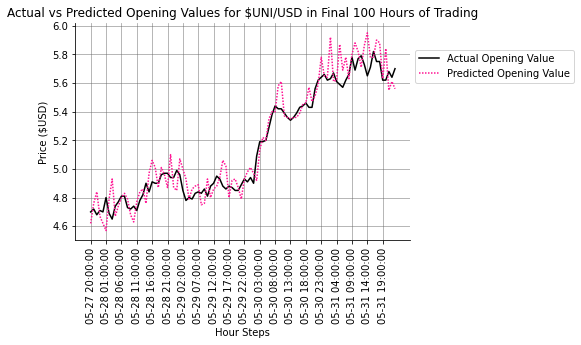

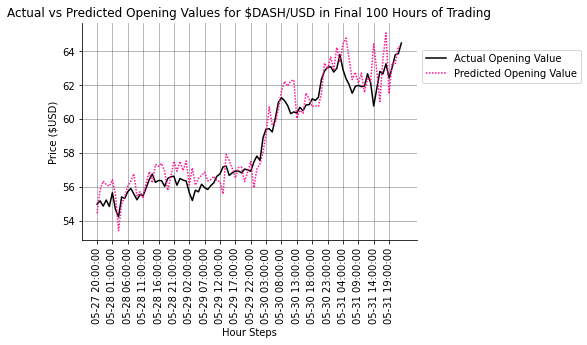

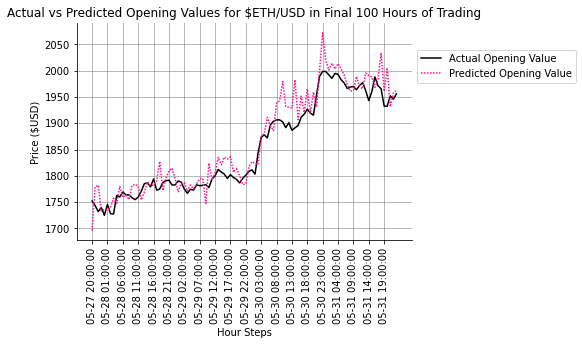

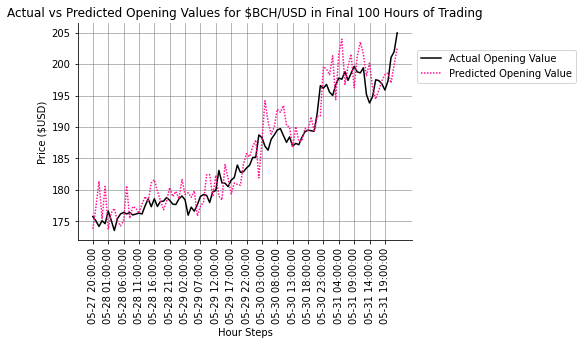

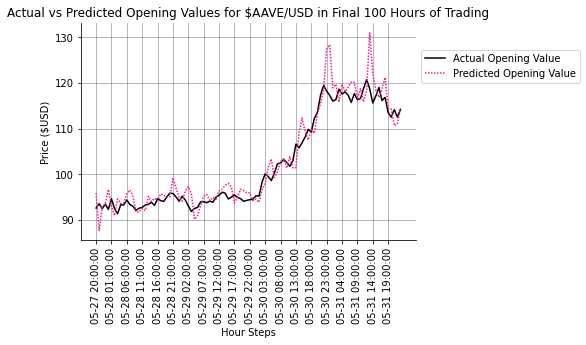

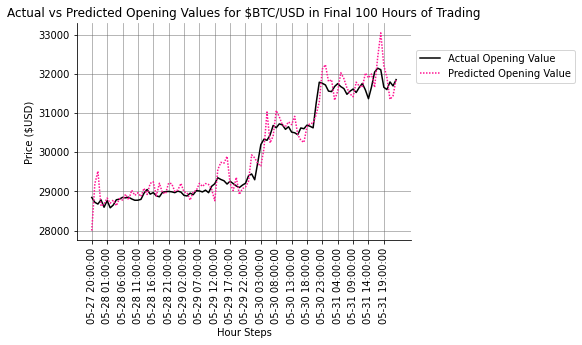

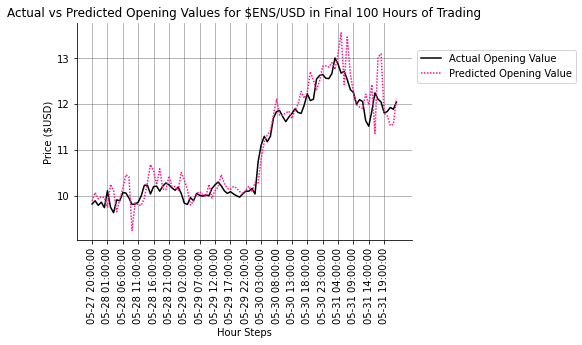

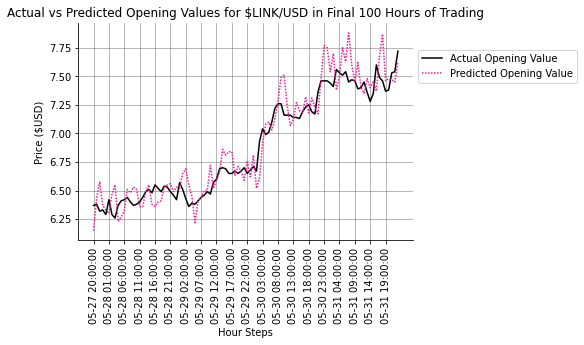

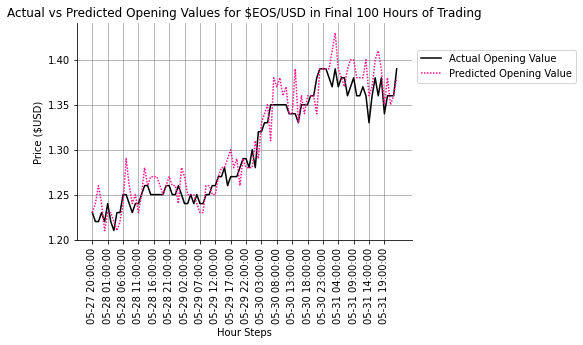

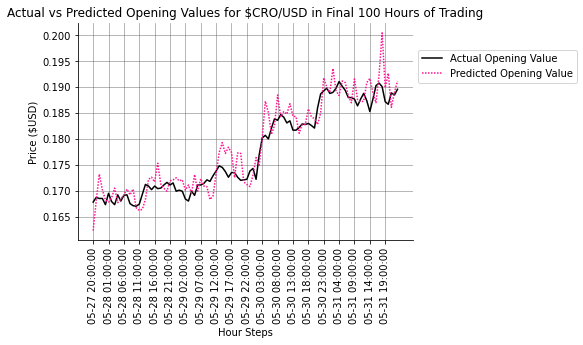

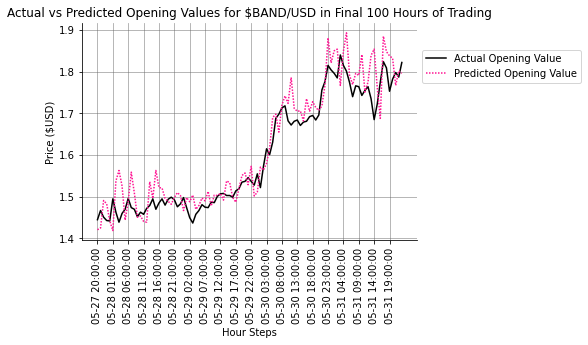

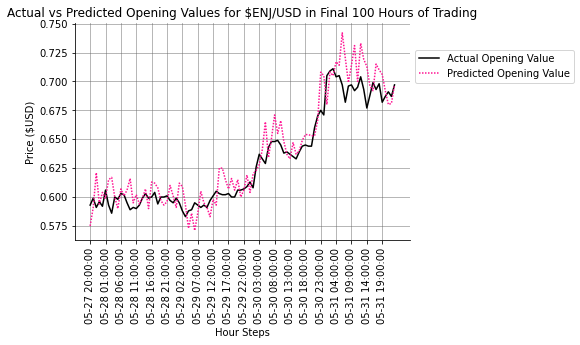

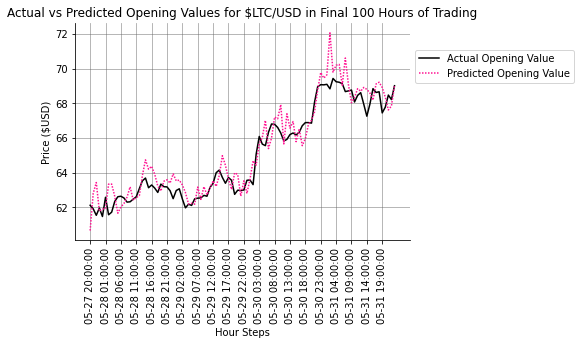

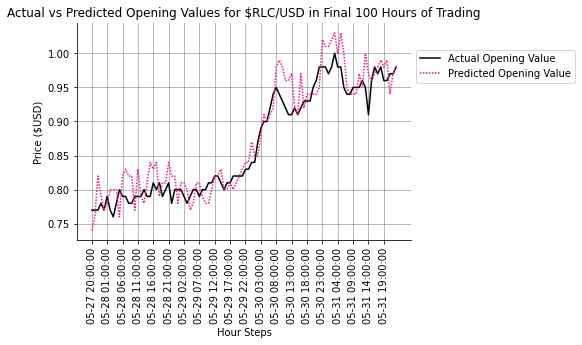

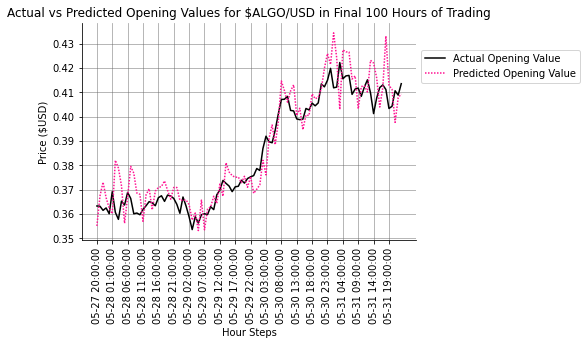

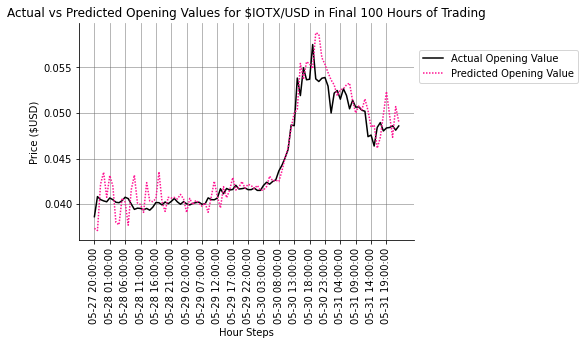

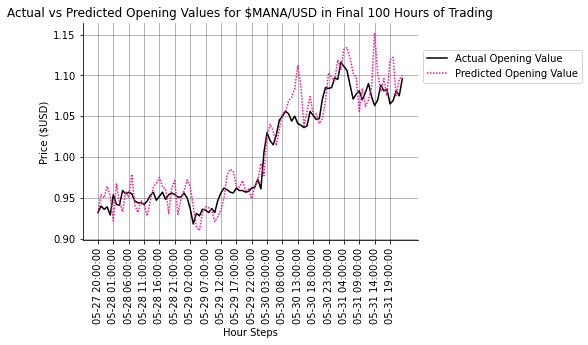

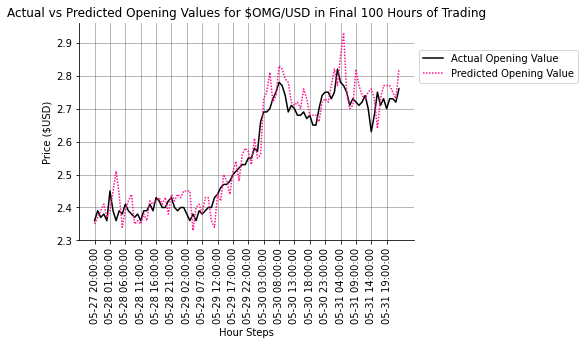

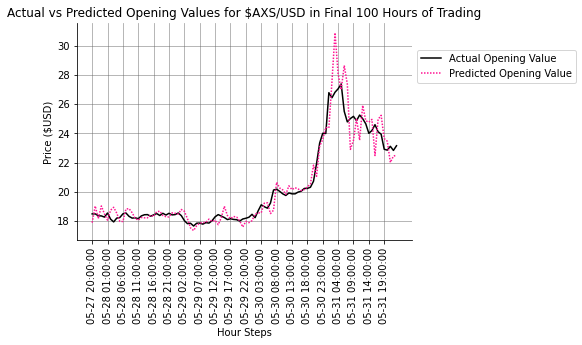

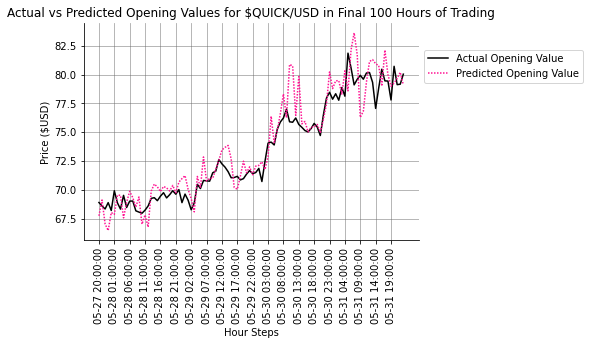

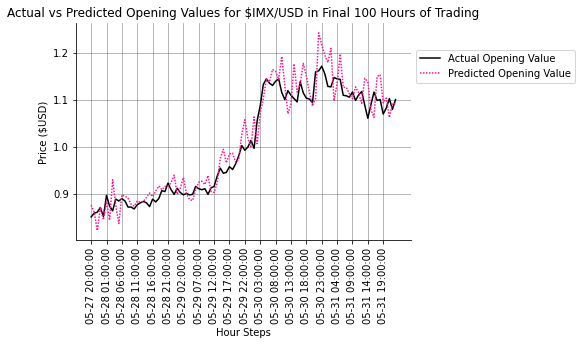

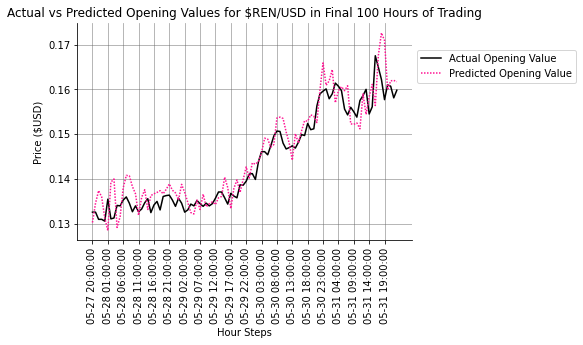

In [11]:
#PLOTTING out opening values series 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


name_array = np.array([i.split('.')[0] for i in name_array])
#print(name_array)

for i,j in enumerate(top_usd['Coin']):
    
    #print(j)
    
    #get opening actual values 
    actual_values = pd.read_csv('data/{}.csv'.format(j))
    a_valz = actual_values.iloc[-100:,1]
    
    #get xtick labels
    labels = actual_values.iloc[-100:,0]
    final = [i.split('2022')[1][1::] for i in labels]
    
    #get index from pickle file for predicted opening values  
    idx = np.where(name_array == j)[0][0]
    predicted_values = pd.DataFrame(obj[1][idx], columns = ['Close', 'Predicted Open', 'High', 'Low'])
    predicted_values = predicted_values.iloc[:,1]
    
    #create plot for the opening values 
    #remove top and rightmost spines to clear things up 
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False
    
    #LINES
    plt.plot(range(100), a_valz, color = 'black', label = 'Actual Opening Value')
    plt.plot(range(100), predicted_values, linestyle = (0, (1, 1)), color = 'deeppink', alpha = 1, label = 'Predicted Opening Value')
    
    #AXES
    plt.title('Actual vs Predicted Opening Values for ${}/USD in Final 100 Hours of Trading'.format(j.split("USD")[0]))
    plt.rcParams['xtick.labelsize']= 10
    plt.xticks(np.arange(0,100,5), labels = final[::5], rotation = 90)
    plt.xlabel('Hour Steps')
    plt.ylabel('Price ($USD)')
    plt.grid(color = 'dimgray', alpha = 0.6)
    plt.legend(bbox_to_anchor=(1, 0.9))
    plt.show()
    

# Visualize the Top 25 ($R^2$) Coin Pairs 

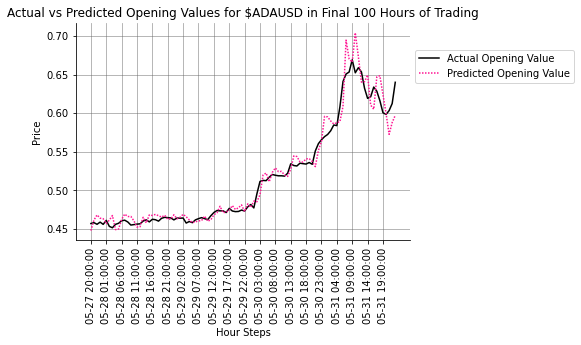

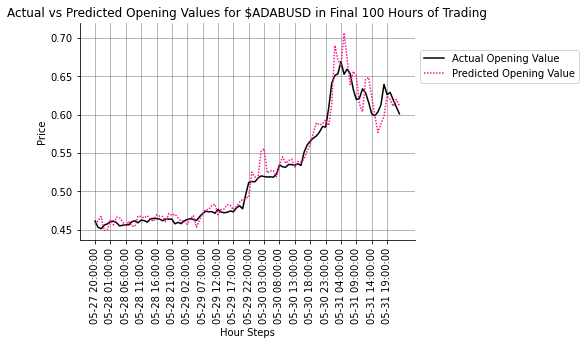

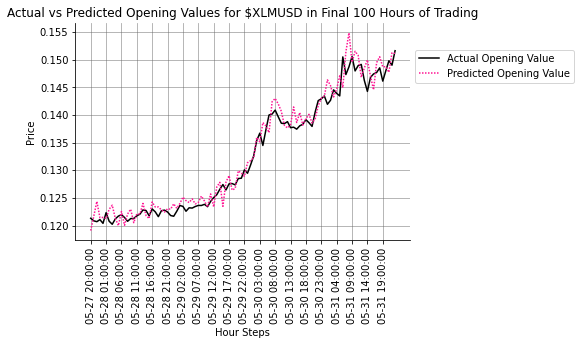

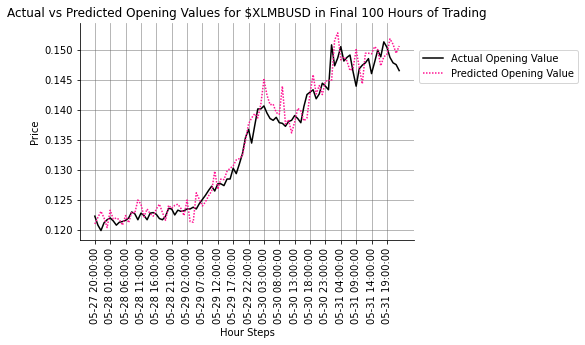

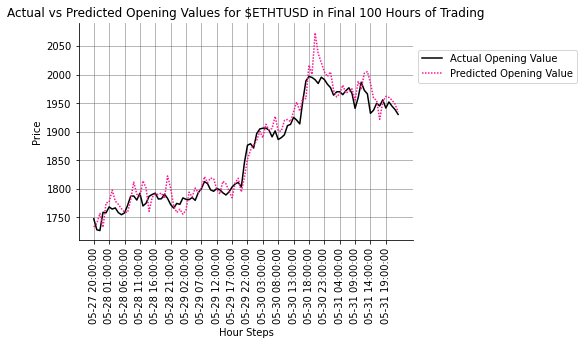

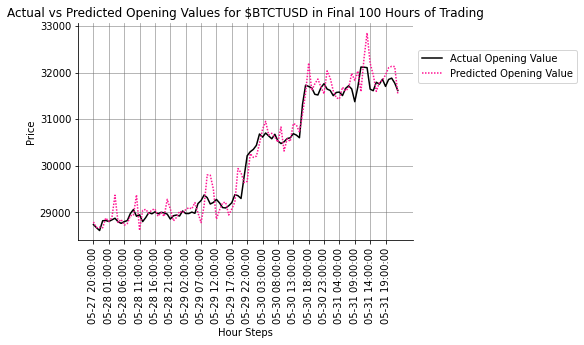

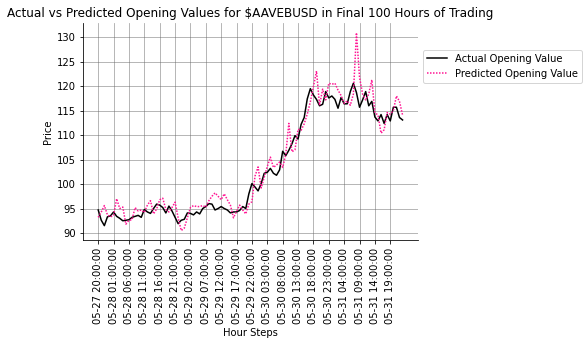

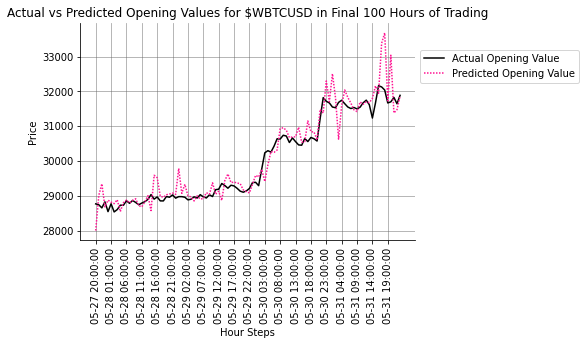

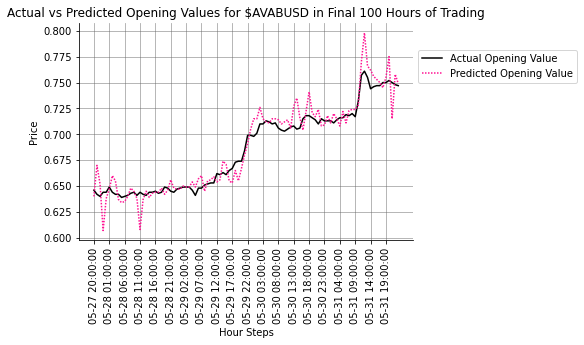

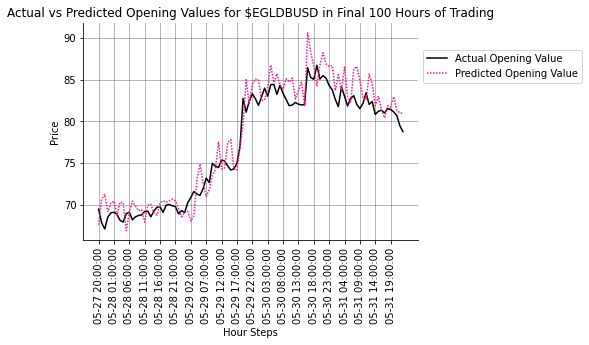

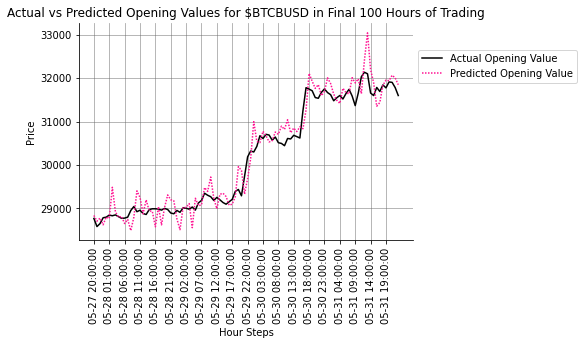

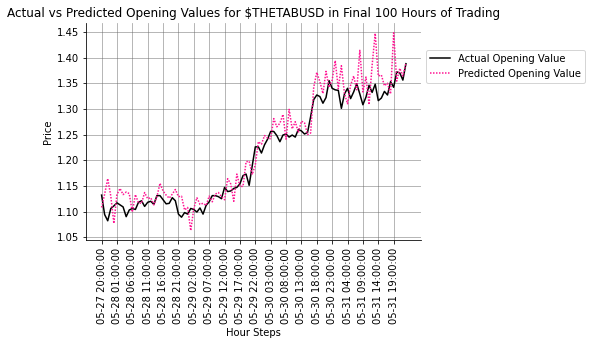

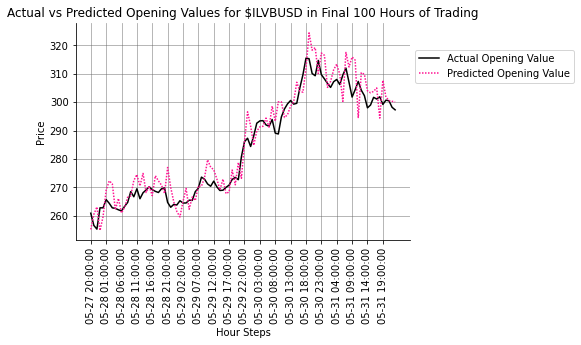

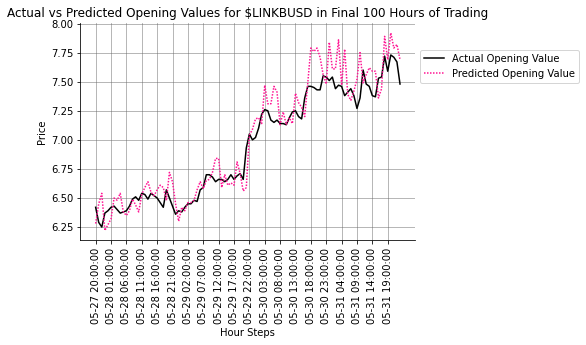

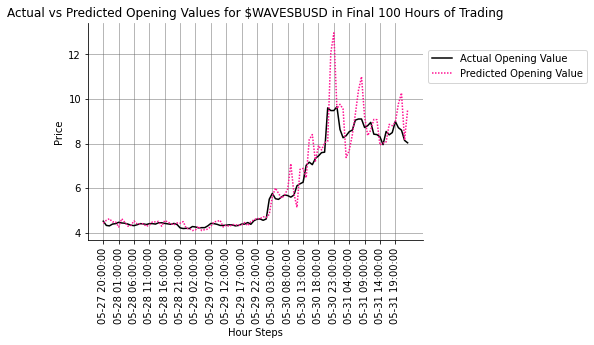

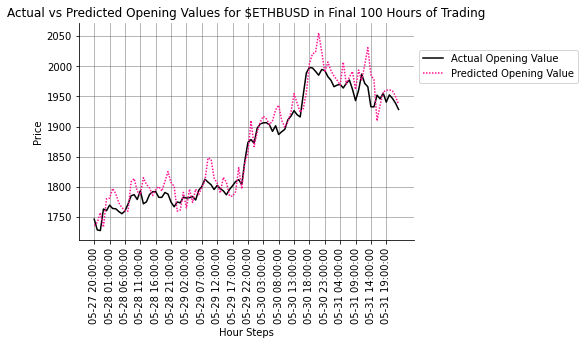

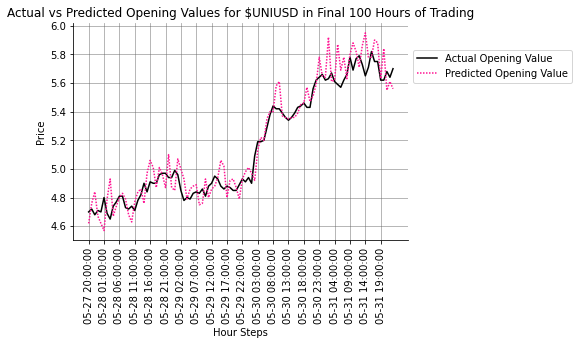

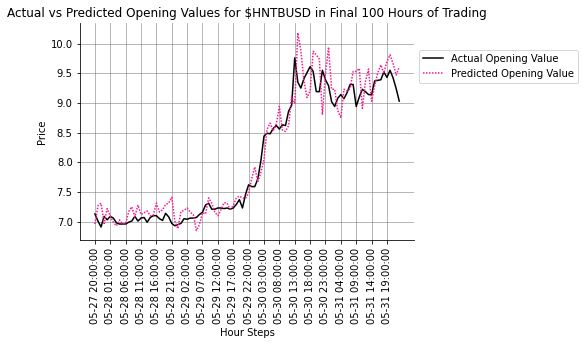

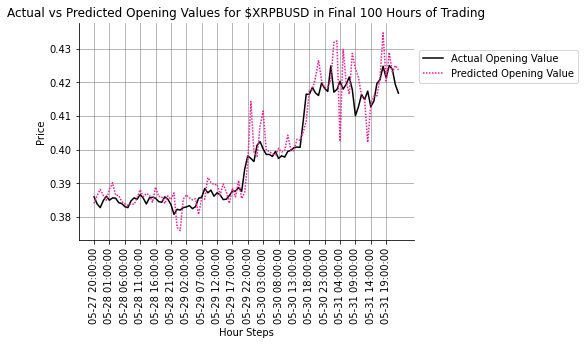

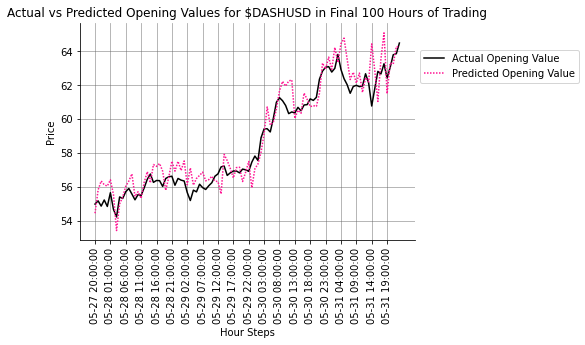

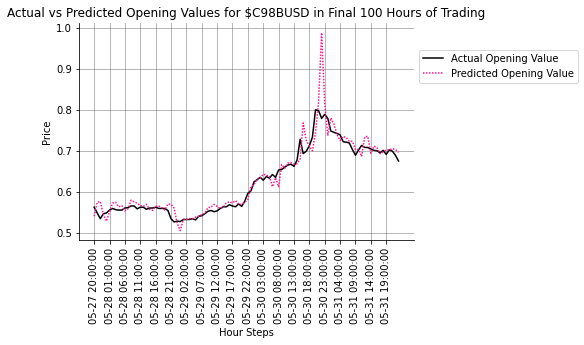

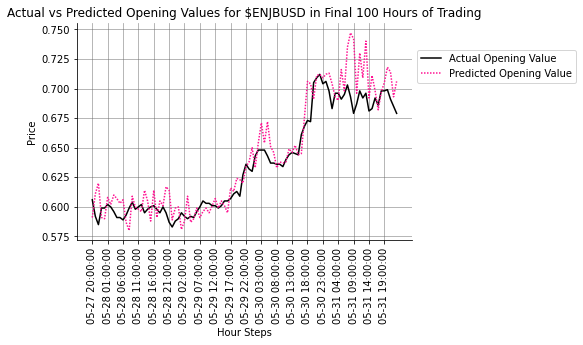

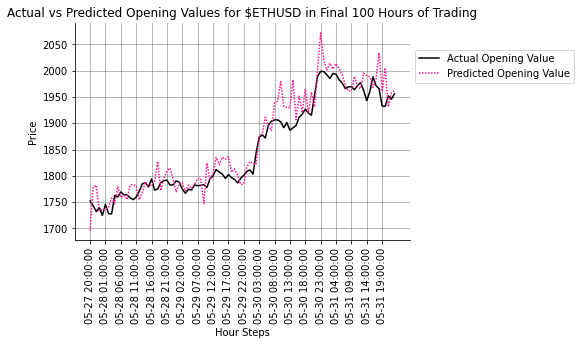

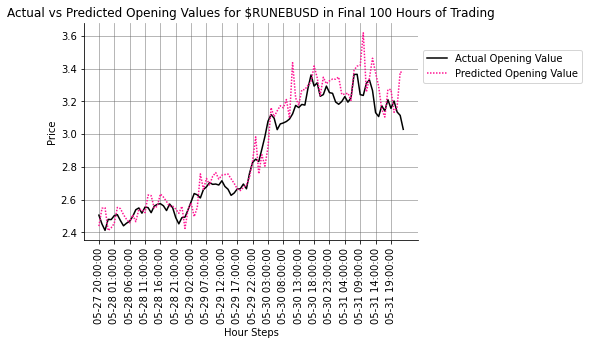

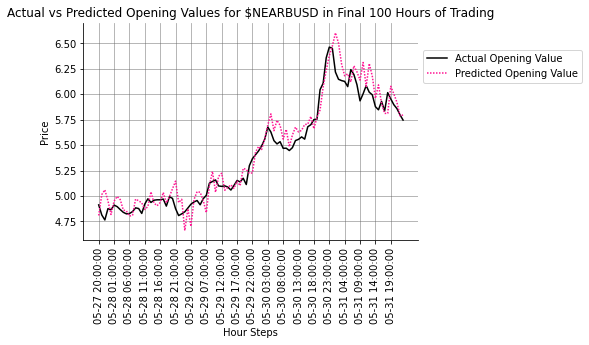

In [12]:
#PLOTTING out opening values series 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


name_array = np.array([i.split('.')[0] for i in name_array])
#print(name_array)

for i,j in enumerate(top_25['Coin']):
    
    #print(j)
    
    #get opening actual values 
    actual_values = pd.read_csv('data/{}.csv'.format(j))
    a_valz = actual_values.iloc[-100:,1]
    
    #get xtick labels
    labels = actual_values.iloc[-100:,0]
    final = [i.split('2022')[1][1::] for i in labels]
    
    #get index from pickle file for predicted opening values  
    idx = np.where(name_array == j)[0][0]
    predicted_values = pd.DataFrame(obj[1][idx], columns = ['Close', 'Predicted Open', 'High', 'Low'])
    predicted_values = predicted_values.iloc[:,1]
    
    #create plot for the opening values 
    #remove top and rightmost spines to clear things up 
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False
    
    #LINES
    plt.plot(range(100), a_valz, color = 'black', label = 'Actual Opening Value')
    plt.plot(range(100), predicted_values, linestyle = (0, (1, 1)), color = 'deeppink', alpha = 1, label = 'Predicted Opening Value')
    
    #AXES
    plt.title('Actual vs Predicted Opening Values for ${} in Final 100 Hours of Trading'.format(j))
    plt.rcParams['xtick.labelsize']= 10
    plt.xticks(np.arange(0,100,5), labels = final[::5], rotation = 90)
    plt.xlabel('Hour Steps')
    plt.ylabel('Price')
    plt.grid(color = 'dimgray', alpha = 0.6)
    plt.legend(bbox_to_anchor=(1, 0.9))
    plt.show()
    

# Bottom 25 ($R^2$) Coin/USD Pairs

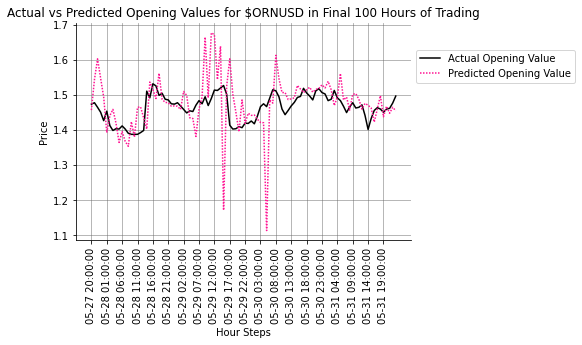

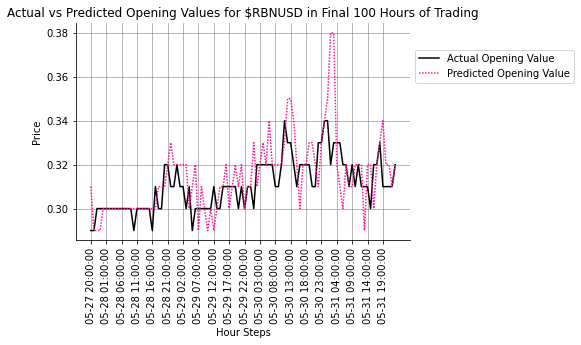

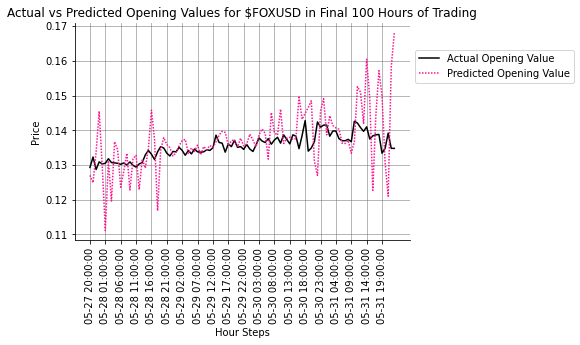

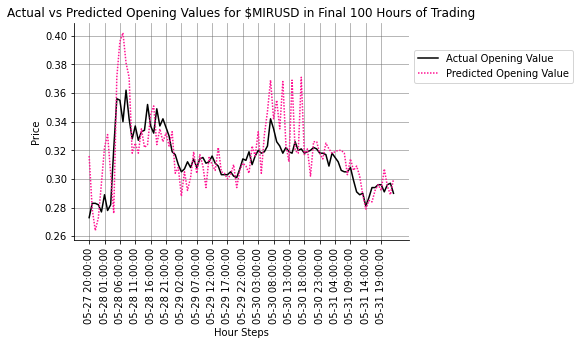

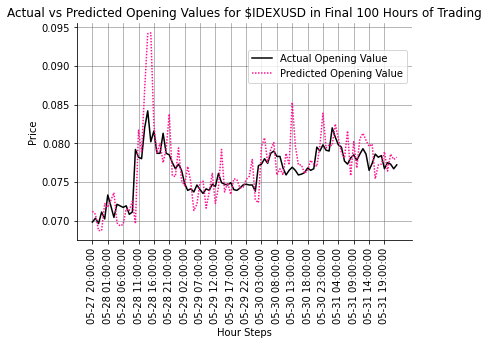

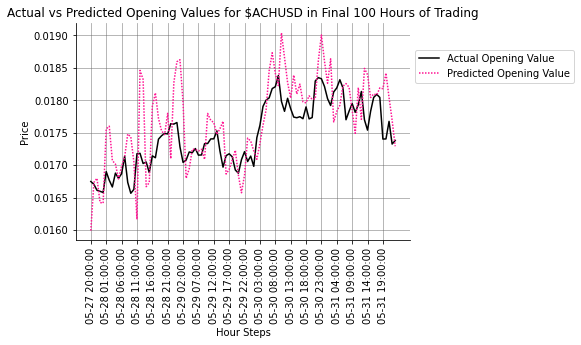

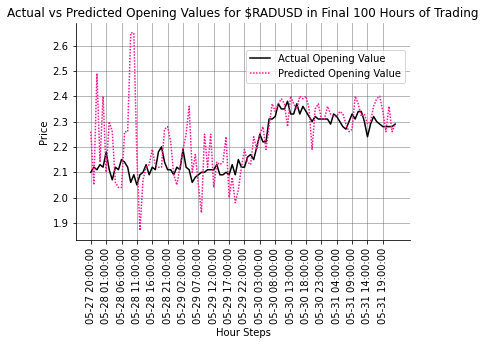

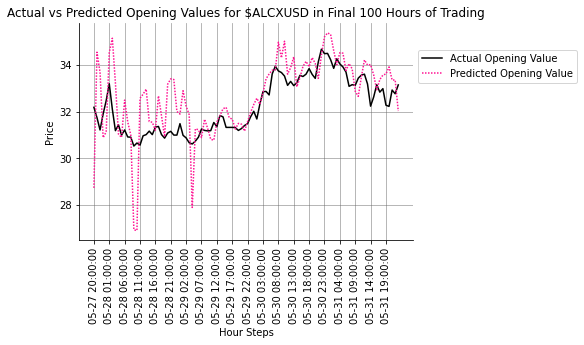

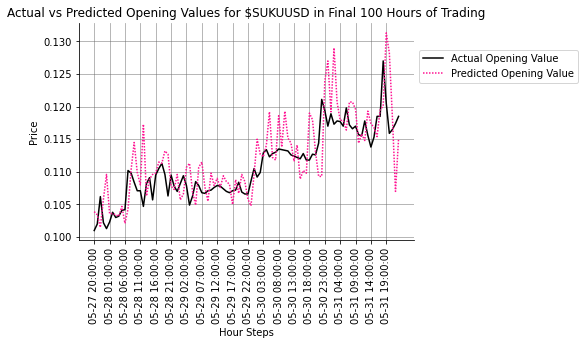

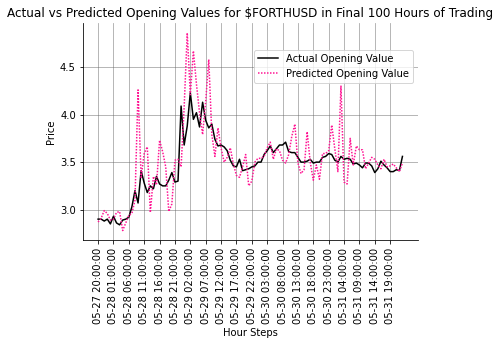

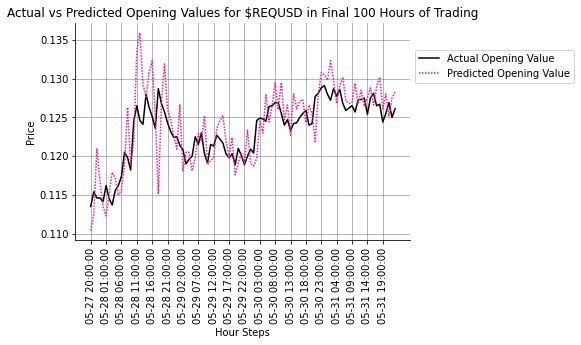

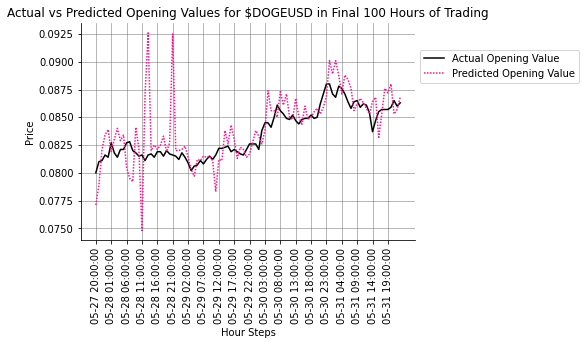

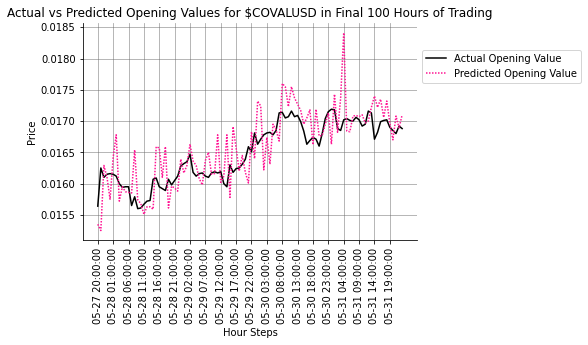

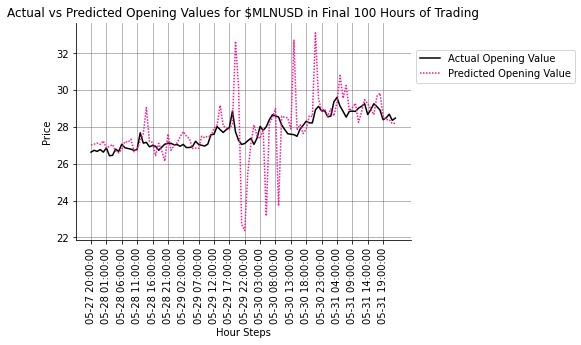

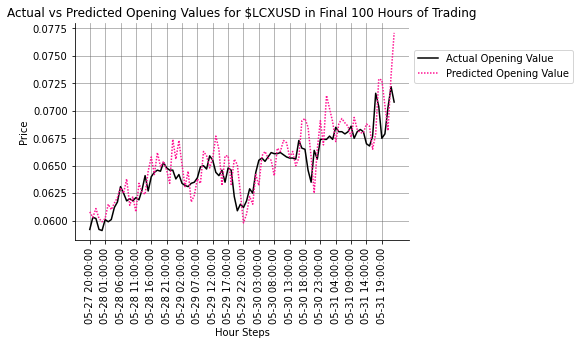

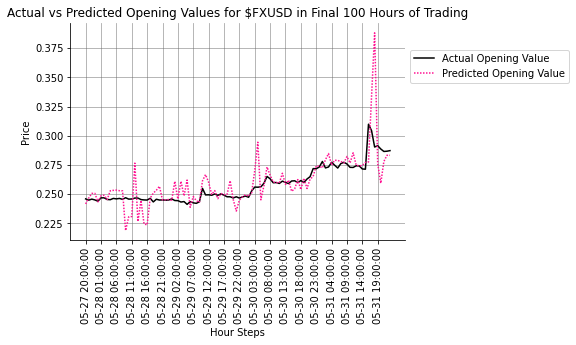

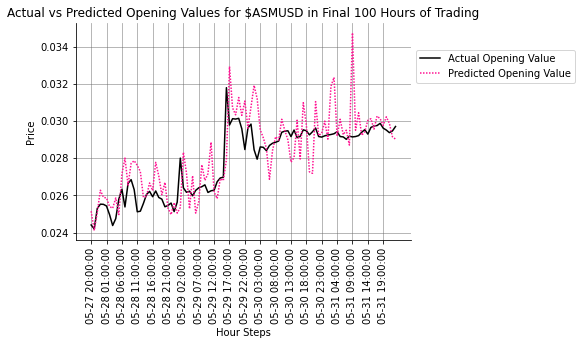

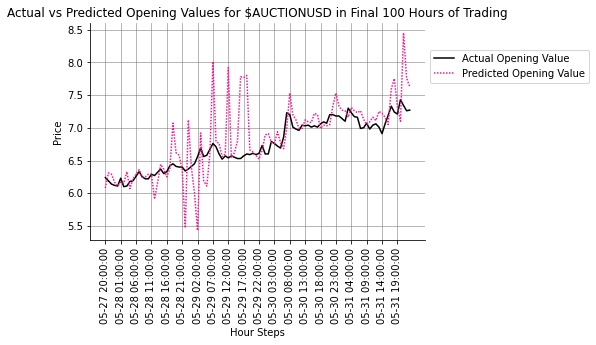

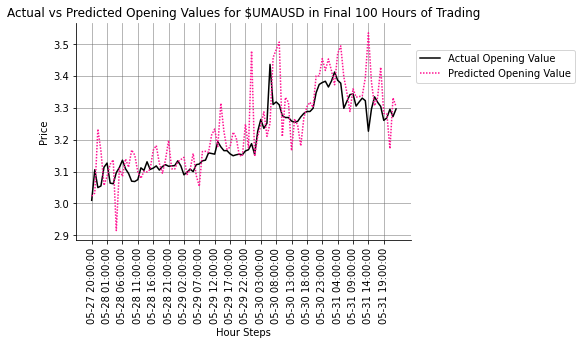

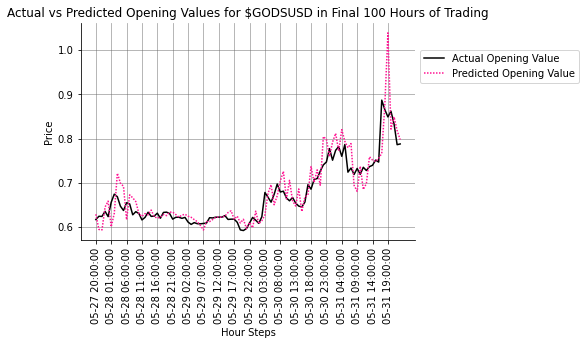

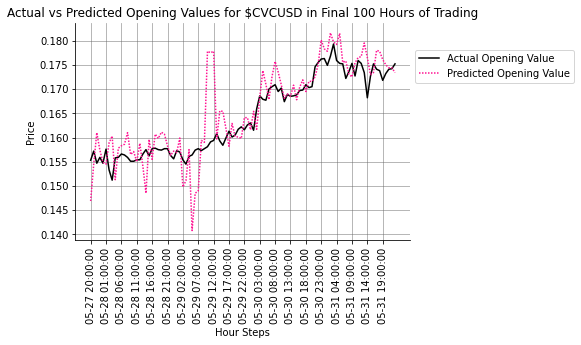

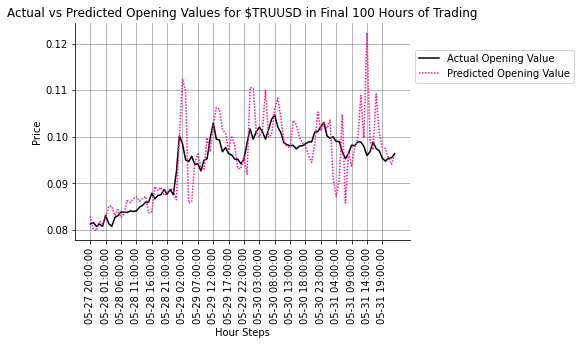

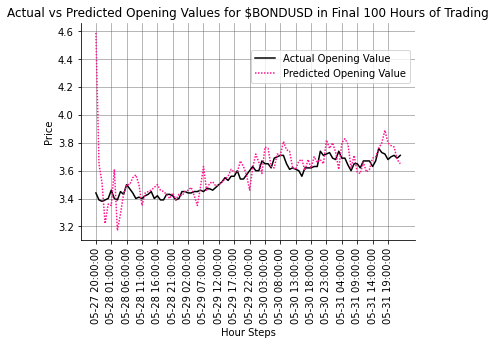

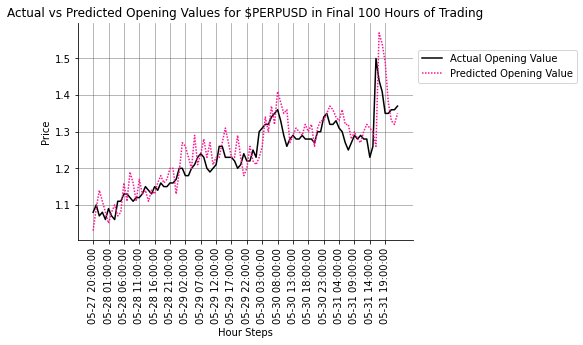

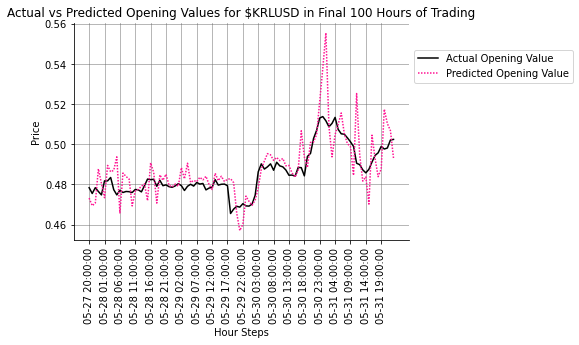

In [13]:
bottom_usd = usd_only.sort_values(by = ['R2 Score'], ascending = True)[0:25]

for i,j in enumerate(bottom_usd['Coin']):
    
    #print(j)
    
    #get opening actual values 
    actual_values = pd.read_csv('data/{}.csv'.format(j))
    a_valz = actual_values.iloc[-100:,1]
    
    #get xtick labels
    labels = actual_values.iloc[-100:,0]
    final = [i.split('2022')[1][1::] for i in labels]
    
    #get index from pickle file for predicted opening values  
    idx = np.where(name_array == j)[0][0]
    predicted_values = pd.DataFrame(obj[1][idx], columns = ['Close', 'Predicted Open', 'High', 'Low'])
    predicted_values = predicted_values.iloc[:,1]
    
    #create plot for the opening values 
    #remove top and rightmost spines to clear things up 
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False
    
    #LINES
    plt.plot(range(100), a_valz, color = 'black', label = 'Actual Opening Value')
    plt.plot(range(100), predicted_values, linestyle = (0, (1, 1)), color = 'deeppink', alpha = 1, label = 'Predicted Opening Value')
    
    #AXES
    plt.title('Actual vs Predicted Opening Values for ${} in Final 100 Hours of Trading'.format(j))
    plt.rcParams['xtick.labelsize']= 10
    plt.xticks(np.arange(0,100,5), labels = final[::5], rotation = 90)
    plt.xlabel('Hour Steps')
    plt.ylabel('Price')
    plt.grid(color = 'dimgray', alpha = 0.6)
    plt.legend(bbox_to_anchor=(1, 0.9))
    plt.show()

## Buy/Sell Decision Visuals

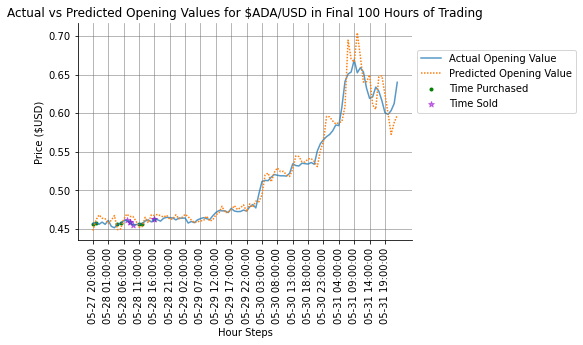

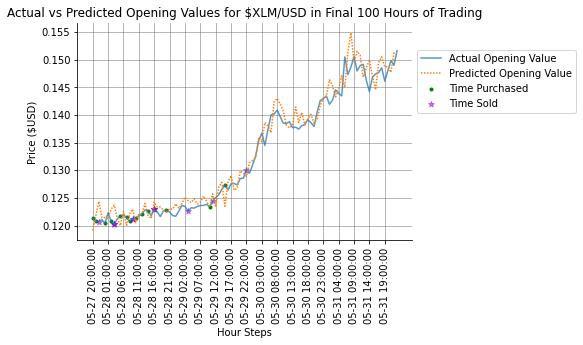

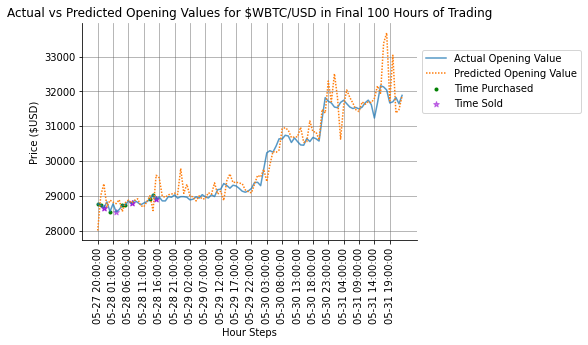

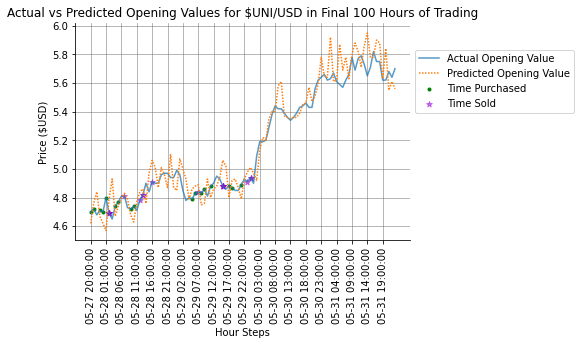

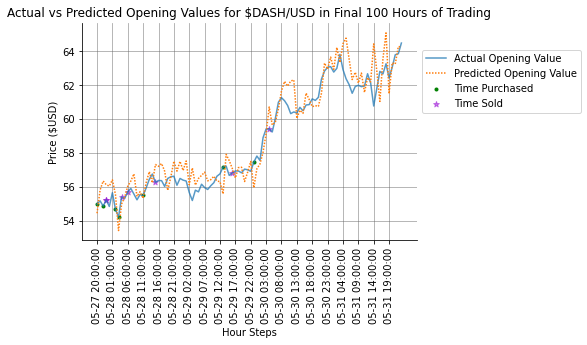

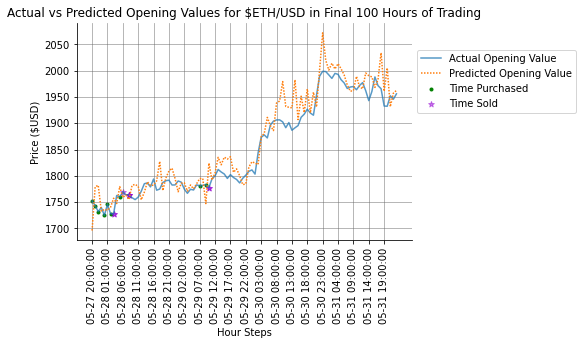

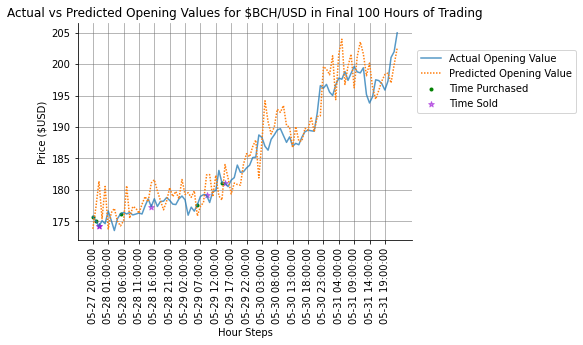

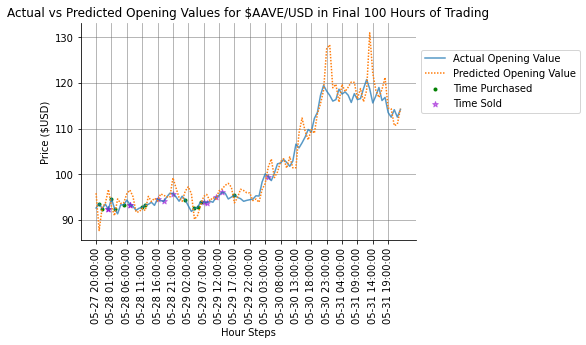

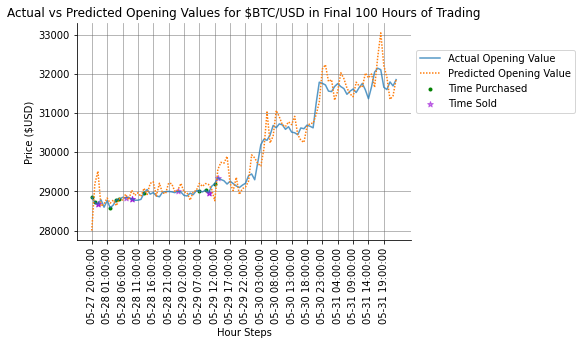

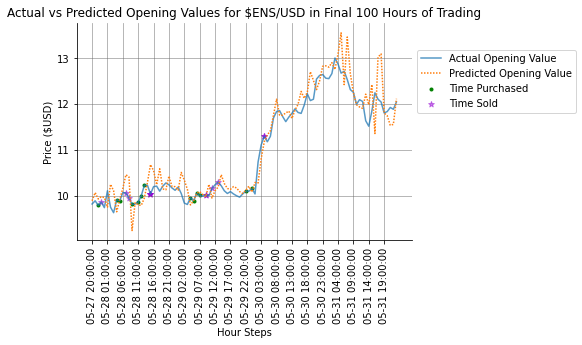

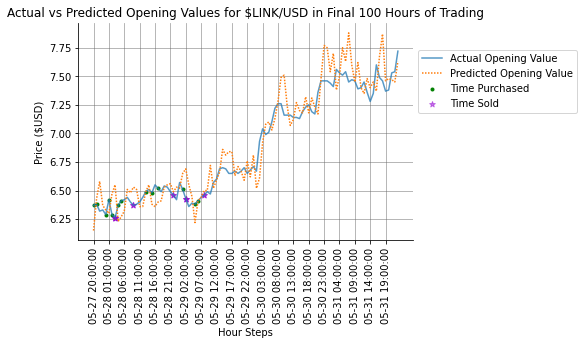

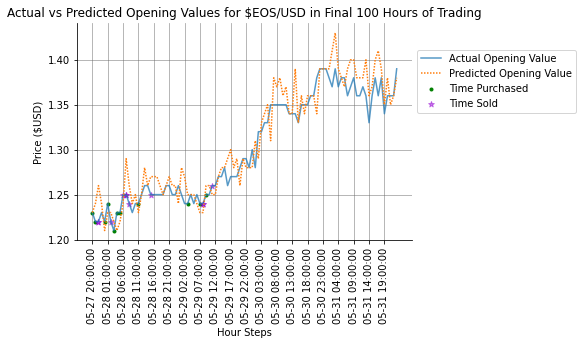

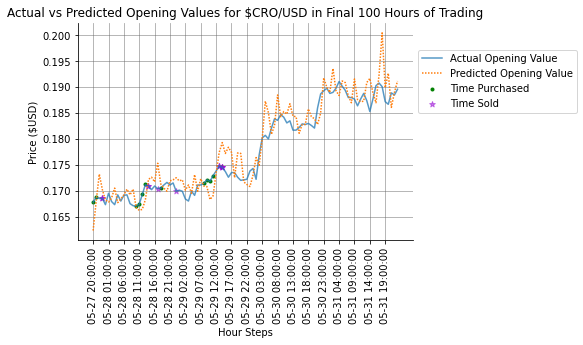

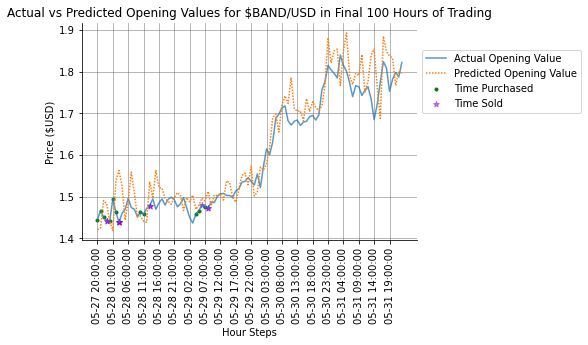

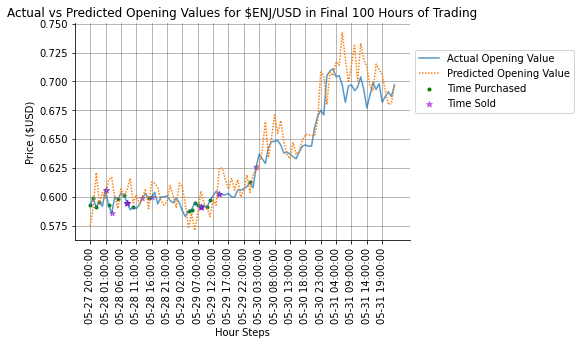

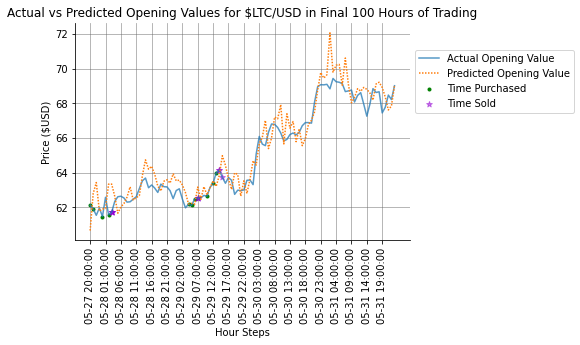

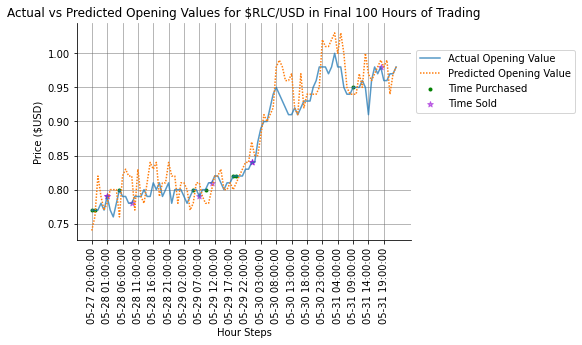

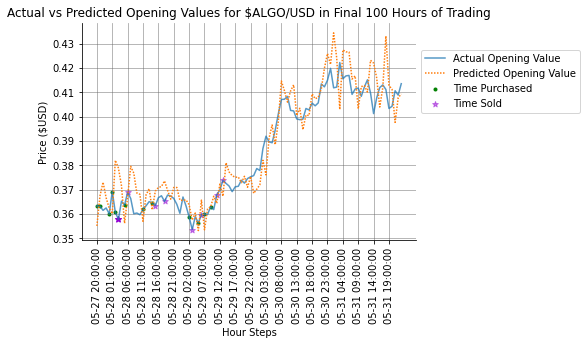

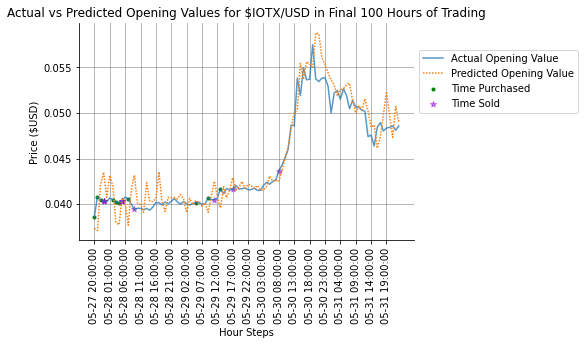

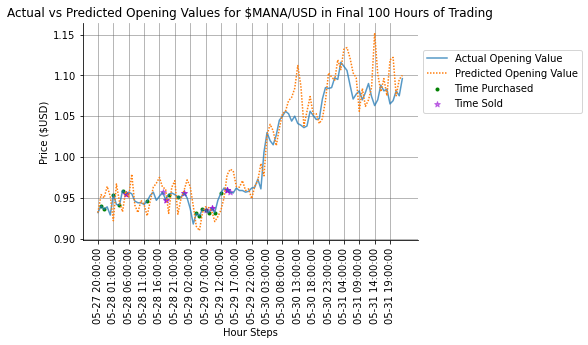

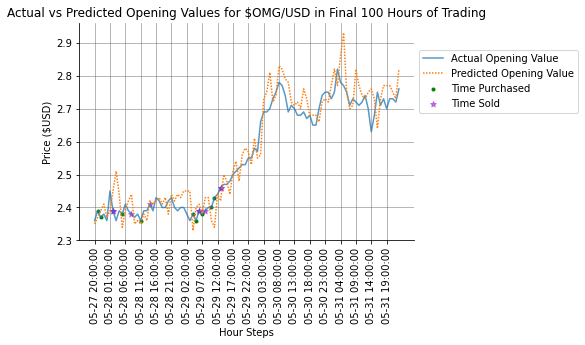

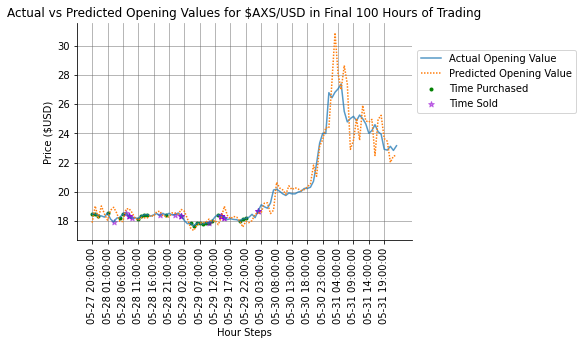

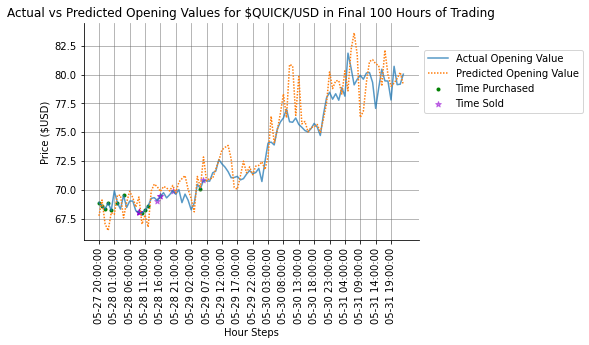

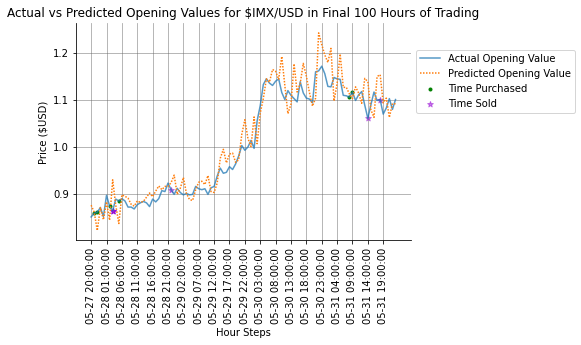

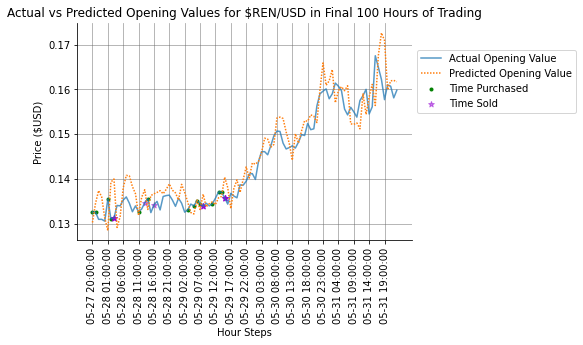

In [86]:
name_array = np.array(obj[0])


for i, j in enumerate(top_usd['Coin']):
    
    dat = moving_averages('{}.csv'.format(j), 25, 85)
    decisions_df = buy_sell(dat)[0]
    sell_decisions = decisions_df.iloc[:,1]
 
    
    buy_decisions = np.where(dat.iloc[:,4] == 1)[0]
    
    #get opening actual values 
    actual_values = pd.read_csv('data/{}.csv'.format(j))
    a_valz = actual_values.iloc[-100:,1]
    
    #get xtick labels
    labels = actual_values.iloc[-100:,0]
    final = [i.split('2022')[1][1::] for i in labels]
    
    #get index from pickle file for predicted opening values  
    idx = np.where(name_array == '{}.csv'.format(j))[0][0]
    predicted_values = pd.DataFrame(obj[1][idx], columns = ['Close', 'Predicted Open', 'High', 'Low'])
    predicted_values = predicted_values.iloc[:,1]
    
    #create plot for the opening values 
    #remove top and rightmost spines to clear things up 
    mpl.rcParams["axes.spines.right"] = False
    mpl.rcParams["axes.spines.top"] = False
    
    #LINES
    plt.plot(range(100), a_valz, label = 'Actual Opening Value', alpha = 0.75)
    plt.plot(range(100), predicted_values, linestyle = (0, (1, 1)),  alpha = 1, label = 'Predicted Opening Value')
    
    #Buy/Sell
    plt.scatter(buy_decisions, dat.iloc[buy_decisions,0], label = 'Time Purchased', marker = '.', alpha = 1, color = 'green')
    plt.scatter(sell_decisions, dat.iloc[sell_decisions,0], label = 'Time Sold', marker = '*', alpha = 0.5, color = 'darkviolet')
    
    #AXES
    plt.title('Actual vs Predicted Opening Values for ${}/USD in Final 100 Hours of Trading'.format(j.split("USD")[0]))
    plt.rcParams['xtick.labelsize']= 10
    plt.xticks(np.arange(0,100,5), labels = final[::5], rotation = 90)
    plt.xlabel('Hour Steps')
    plt.ylabel('Price ($USD)')
    plt.grid(color = 'dimgray', alpha = 0.6)
    plt.legend(bbox_to_anchor=(1, 0.9))
    plt.show()
    
    
    
    

In [14]:
#Visuals with Buy/Sell Decisions

In [76]:
# for i, j in enumerate(top_usd['Coin']):
    
#     dat = moving_averages('{}.csv'.format(j), 25, 85)
#     decisions = buy_sell(dat)
    
#     #print(decisions[0])
    
#     #get opening actual values 
#     actual_values = pd.read_csv('data/{}.csv'.format(j))
#     a_valz = actual_values.iloc[-100:,1]
    
#     #get xtick labels
#     labels = actual_values.iloc[-100:,0]
#     final = [i.split('2022')[1][1::] for i in labels]
    
#     #get index from pickle file for predicted opening values  
#     idx = np.where(name_array == '{}.csv'.format(j))[0][0]
    
#     decisions = pd.DataFrame(decisions[0])
#     #print(decisions)
    
#     buy_decisions = np.where(dat.iloc[:,4] == 1)[0]
    
    
#     print(dat.iloc[buy_decisions,0])

    
    
    

   